# MODEL 1: Linear solution (MLP with Dropout)

In this exercise, we are asked to build a `Seq2Vec` model using only nn.Linear() layers. Using the values of a set of features at timepoints $t-k$ through $t-1$, we are asked to predict the following targets at timepoint $t$: 

- `p(mbar)`, atmospheric pressure
- `T (degC)`, air temperature
- `rh (%)`, relative humidity
- `wv(m/s)`, wind velocity

Because an `MLP` can only take a fixed number of values, we will first initialize the model at $k = 4$. Then, once we get that model working, we will set $k$ as a hyperparameter and iterate through `{4, 6, 8}`, along with two learning rate values`{0.001, 0.002}`and two dropout values`{0.2, 0.5}`.

## We define the first model using k = 4 and no tuning yet:

In [1]:
# Let's check our current working directory 
import os
print(os.getcwd())

C:\Users\usuario\RecogniChess


In [2]:
# Let's import the necessary dependencies
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import pandas as pd

In [3]:
# We determine whether CUDA is available 
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce GTX 960M


In [4]:
# We empty the CUDA cache for good measure and verify cache and RAM are at zero
torch.cuda.empty_cache()
print(f"CUDA cache used: {torch.cuda.memory_reserved() / 1e6:.1f} MB") 
print(f"CUDA RAM used: {torch.cuda.memory_allocated() / 1e6:.1f} MB")

CUDA cache used: 0.0 MB
CUDA RAM used: 0.0 MB


We are ready to initialize our model class. We will use a very simple architecture with only one hidden layer containing `100` units. The hidden layer output will go through a ReLU activation function to yield the predicted values for each of our four target variables. Dropout will be set at `0.2` for now. Note that we will define $k = 4$ right away, in the very first line, in order to establish the input features as $11$ * $k$ right off the bat. This way we can simply write $k = k$ as needed in the subsequent cells.

In [5]:
# We define our model class

k = 4 # We will set k to be the number of timesteps that we will consider prior to time t 

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features1, out_features, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features1)
        self.fc2 = nn.Linear(hidden_features1, out_features)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
torch.manual_seed(42)
model = MLP(in_features=11*k, hidden_features1=100, out_features=4, dropout_rate=0.2).to(device)

In [6]:
# We set the model to CUDA and verify its structure
model.to(device)
model

MLP(
  (fc1): Linear(in_features=44, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

We see that the input features to the model will be `44`. This means that we will concatenate the values of our `11` features four times (as $k = 4$), in sequential order, into a single array that will be passed to the model. This is not the best way to take into account previous timepoints, but it is one of the few viable options that an `MLP` allows for timeseries data. As a limitation to this approach, we note that this can only work for small values of $k$, as every new timestep increases the feature set by `11`, in our case.

We will now proceed to define our Dataset subclass, which will be used to perform the following operations: 

- Retrieve the CSV files containing the **training** and **test** data from their respective directories
- Compute a new feature based on the timestamp column for the `hour` at which the measurements were taken
- Divide the data columns given by the CSVs into **inputs** and **targets**
- Calculate the `mean` and `std` for input and targets, and use them to normalize the data
- Convert the resulting objects into `torch.tensors` that can be readily passed into DataLoaders

In [7]:
class WeatherDataset(Dataset):
    
    def __init__(self, root_dir, train_or_test, sep=',', k=k):
        self.root_dir = root_dir      
        self.df = pd.read_csv(os.path.join(root_dir, train_or_test), header=0, parse_dates=[0])
        
        self.df['hour'] = self.df.iloc[:,0].dt.hour.astype(np.float32) # We will add the hour as a feature, as this could help our model

        self.input_cols = ['hour'] + list(self.df.columns[3:5]) + list(self.df.columns[6:12]) + list(self.df.columns[13:15])
        self.target_cols = list(self.df.columns[[1, 2, 5, 12]])
        
        self.k = k

        # It is imperative that we calculate the mean and standard deviation of the input and target values in order to normalize
        self.input_mean = self.df[self.input_cols].mean().values.astype(np.float32)
        self.input_std = self.df[self.input_cols].std().values.astype(np.float32)
        self.target_mean = self.df[self.target_cols].mean().values.astype(np.float32)
        self.target_std = self.df[self.target_cols].std().values.astype(np.float32)

    def __len__(self):
        return len(self.df) - self.k
    
    def __getitem__(self, idx):
        input_values = np.array([self.df.iloc[i][self.input_cols] for i in range(idx, idx+self.k)], dtype=np.float32)
        target_values = np.array(self.df.iloc[idx+self.k][self.target_cols], dtype=np.float32)

        # We normalize the input values
        input_values = (input_values - self.input_mean) / self.input_std

        # We normalize the target values
        target_values = (target_values - self.target_mean) / self.target_std

        # We reshape the input values to flatten the dimension containing the sequence length (k)
        input_values = input_values.reshape(-1)

        # Verify the input and target shapes
        assert input_values.shape == (self.k*len(self.input_cols),), f"Input shape mismatch: {input_values.shape}"
        assert target_values.shape == (len(self.target_cols),), f"Target shape mismatch: {target_values.shape}"

        # Convert input and targets to torch.tensors
        input_tensor = torch.tensor(input_values, dtype=torch.float32)
        target_tensor = torch.tensor(target_values, dtype=torch.float32)

        return input_tensor, target_tensor


In [8]:
# We are ready to define our training and test datasets
train_dataset = WeatherDataset(root_dir=r"C:\Users\usuario\RecogniChess\HW4", train_or_test='weather_train.csv', k=k)
test_dataset = WeatherDataset(root_dir=r"C:\Users\usuario\RecogniChess\HW4", train_or_test='weather_test.csv', k=k)

In [9]:
# We will now print the length of each dataset to verify the __len__() function works
print("The training dataset contains:", len(train_dataset), "rows")
print("The test dataset contains", len(test_dataset), "rows")

The training dataset contains: 56068 rows
The test dataset contains 14015 rows


For each dataset, the length value we obtain is equal to the original length of the dataset $-$ $k$

In [10]:
# We will now print the first example in the training dataset to verify the __getitem__() function works
print("Training dataset example (normalized):" , train_dataset[0])

Training dataset example (normalized): (tensor([-1.5171, -2.0756, -1.9517, -1.3158, -1.4835, -0.7882, -1.4858, -1.4886,
         2.2466, -1.2527,  0.2145, -1.3726, -2.1742, -2.0966, -1.3439, -1.5413,
        -0.7839, -1.5428, -1.5457,  2.3560, -1.2527,  0.1869, -1.2281, -2.1683,
        -2.0805, -1.3425, -1.5341, -0.7861, -1.5352, -1.5385,  2.3543, -1.2527,
        -0.0784, -1.0836, -2.1977, -2.1332, -1.3505, -1.5534, -0.7797, -1.5542,
        -1.5600,  2.3899, -1.3597,  0.7577]), tensor([ 1.0332, -2.2056,  0.9693, -1.1348]))


Although they are normalized, we see that our model has concatenated the values of our 11 features at:

- Timestep t-4 : -1.5171, -2.0756, -1.9517, -1.3158, -1.4835, -0.7882, -1.4858, -1.4886,  2.2466, -1.2527,  0.2145
- Timestep t-3 : -1.3726, -2.1742, -2.0966, -1.3439, -1.5413, -0.7839, -1.5428, -1.5457,  2.3560, -1.2527,  0.1869
- Timestep t-2 : -1.2281, -2.1683, -2.0805, -1.3425, -1.5341, -0.7861, -1.5352, -1.5385,  2.3543, -1.2527, -0.0784,
- Timestep t-1 : -1.0836, -2.1977, -2.1332, -1.3505, -1.5534, -0.7797, -1.5542, -1.5600,  2.3899, -1.3597,  0.7577

In order to predict the 4 targets at: 

- Timestep t :     1.0332, -2.2056,  0.9693, -1.1348

In [11]:
# Let's make sure we can subset this example to get its target value (label), which corresponds to the Temperature, DewPoint, RelativeHumidity and WindSpeed values at timepoint t
print("Target values of training dataset example 1 (normalized):" , train_dataset[0][1])

Target values of training dataset example 1 (normalized): tensor([ 1.0332, -2.2056,  0.9693, -1.1348])


In [12]:
# We are finally ready to define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

Before proceeding, one final litmus test is in order. Namely, we need to verify that our matrix sizes are compatible with each other. If our model has been defined correctly, we should have: 

- Model inputs: consisting of batch size `32` in dimension $1$ and the $k$-long concatenated feature values in dimension $2$ (`44`)
- Model targets: consisting of batch size `32`in dimension $1$ and the `4`model targets (labels)
- Model outputs: consisting of batch size `32`in dimension $1$ and the `4`predicted values

Where the shape of outputs and targets must be the same in order to effectively compute a Loss at each model pass:

In [14]:
# Let's get a batch of inputs and targets to verify we have the right matrix shapes

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

# Pass the inputs through the model
outputs = model(inputs)
outputs = outputs.to(device)

# Print the shapes of the tensors
print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Outputs shape: {outputs.shape}")

Inputs shape: torch.Size([32, 44])
Targets shape: torch.Size([32, 4])
Outputs shape: torch.Size([32, 4])


We get exactly what we expected. The first dimension is the batch size, `32`, which is common to all three tensors. Then, our model then takes `11` outputs at 4 different timpoints ($t-k$ ... $t-1$) and concatenates them ($11$ x $k$) to create an input shape of `44` features. These are used to predict `4` targets (y_preds) at timepoint `t` and compare them to the true labels (y_trues) at timepoint `t`. We have verified that the shape of our model targets and outputs is the same, and so we are ready to proceed to model training:

## First model pass (k = 4; no tuning yet)

In [21]:
# We begin by splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # We will set the batch size to 64 to speed things up
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) # We will set the batch size to 64 to speed things up

In [ ]:
# We define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002) # We will also set the learning rate relatively high 

# We define the number of epochs to train for
num_epochs = 10
# We define the number of iterations to print loss at
print_every = 500
# We initialize the iteration counter
iteration = 0

# We initialize lists to store training and validation losses and R2s for each epoch
train_losses = []
val_losses = []
train_r2s = []
val_r2s = []

In [22]:
##############
# TRAINING LOOP #
#############

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_train_r2 = 0.0
    epoch_val_loss = 0.0
    epoch_val_r2 = 0.0
    model.train()
    for inputs, targets in train_loader:
        # Move the inputs and targets to the device (GPU or CPU)
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        train_loss = criterion(outputs, targets)
        train_r2 = torchmetrics.functional.r2_score(outputs, targets)
        
        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        epoch_train_r2 += train_r2.item()  
        
        # Calculate the average training loss and R2 for the epoch
        train_loss = epoch_train_loss / len(train_loader)
        train_r2 = epoch_train_r2 / len(train_loader)  
                                      
        # Print the training loss at every print_every iterations
        if iteration % print_every == 0:
            print(f"Iteration {iteration} - Training Loss: {train_loss:.4f} Training R-squared: {train_r2:.4f}")
            
        iteration += 1
       
    # Compute the average training loss and R2 for the epoch
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    avg_epoch_train_r2 = epoch_train_r2 / len(train_loader)
    
    # Append the training loss and R2 to the lists
    train_losses.append(avg_epoch_train_loss)
    train_r2s.append(avg_epoch_train_r2)
    
    ###############
    # VALIDATION LOOP #
    ##############
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move the inputs and targets to the device (GPU or CPU)
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            val_r2 = torchmetrics.functional.r2_score(outputs, targets)
            
            epoch_val_loss += val_loss.item()
            epoch_val_r2 += val_r2.item()  
        
        # Compute the average validation loss and R2 for the epoch
        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        avg_epoch_val_r2 = epoch_val_r2 / len(val_loader)  
        
        # Append the validation loss and R2 to the lists
        val_losses.append(avg_epoch_val_loss)
        val_r2s.append(avg_epoch_val_r2)
    
    # Print the average loss and R2 for the epoch
    print(f"Epoch {epoch+1} - Training Loss: {avg_epoch_train_loss:.4f} Training R-squared: {avg_epoch_train_r2:.4f} Validation Loss: {avg_epoch_val_loss:.4f} Validation R-squared: {avg_epoch_val_r2:.4f}")


Iteration 0 - Training Loss: 0.0003 Training R-squared: 0.0016
Iteration 500 - Training Loss: 0.1227 Training R-squared: 0.7645
Epoch 1 - Training Loss: 0.1364 Training R-squared: 0.8562 Validation Loss: 0.1111 Validation R-squared: 0.8820
Iteration 1000 - Training Loss: 0.1036 Training R-squared: 0.6755
Epoch 2 - Training Loss: 0.1314 Training R-squared: 0.8620 Validation Loss: 0.1101 Validation R-squared: 0.8822
Iteration 1500 - Training Loss: 0.0883 Training R-squared: 0.5824
Epoch 3 - Training Loss: 0.1296 Training R-squared: 0.8636 Validation Loss: 0.1074 Validation R-squared: 0.8852
Iteration 2000 - Training Loss: 0.0728 Training R-squared: 0.4912
Epoch 4 - Training Loss: 0.1279 Training R-squared: 0.8656 Validation Loss: 0.1072 Validation R-squared: 0.8858
Iteration 2500 - Training Loss: 0.0576 Training R-squared: 0.3976
Epoch 5 - Training Loss: 0.1272 Training R-squared: 0.8673 Validation Loss: 0.1067 Validation R-squared: 0.8863
Iteration 3000 - Training Loss: 0.0429 Training 

We stored the performance metrics at every epoch, so we can now plot the learning curves for both training and validation sets:

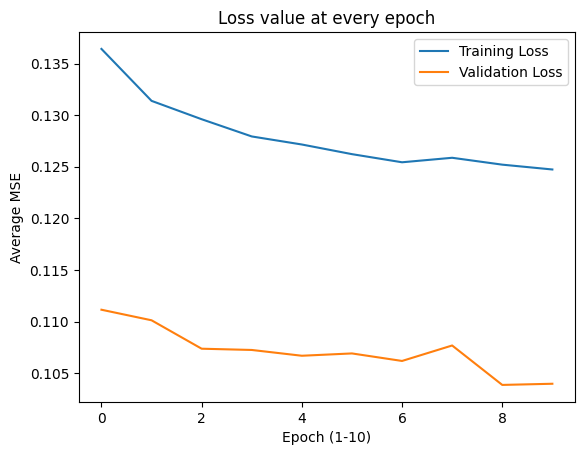

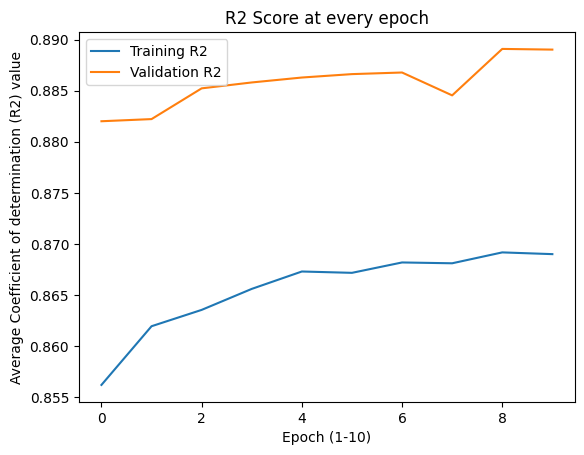

In [25]:
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss value at every epoch')
plt.xlabel('Epoch (1-10)')
plt.ylabel('Average MSE')
plt.show()

# Plot the training and validation R2 scores
plt.plot(train_r2s, label='Training R2')
plt.plot(val_r2s, label='Validation R2')
plt.legend()
plt.title('R2 Score at every epoch')
plt.xlabel('Epoch (1-10)')
plt.ylabel('Average Coefficient of determination (R2) value')
plt.show()

The model seems to be learning at every epoch and performance is quite high already, approaching R2 values in the low 90s! More importantly, it is clear that the model is **not overfitting**, as validation performance is actually a bit better than training performance. However, improvements are rather slow and we still have a long way to go. Namely, we need to set $k$ as a hyperparameter and test three different lengths: `{4, 6, 8}`. That is in addition to checking two different `learning rate` values `{0.001, 0.002}` and two different `dropout` values `{0.2, 0.5}`, and of course training for longer. 